# Part 4: Recurrent Neural Network

### In this section, the cleaned text will be converted to a suitable form using one-hot encoding, then used to train a RNN with LSTM layer.

### This section will also explore and test different methods of fine-tuning the RNN and evaluating its effectiveness

In [ ]:
import sys
!{sys.executable} -m pip install pandas_profiling
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install imblearn
!{sys.executable} -m pip install scikit-learn-intelex
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m spacy download en_core_web_md
!{sys.executable} -m pip install wget
!{sys.executable} -m pip install unzip

In [102]:
!{sys.executable} -m wget http://nlp.stanford.edu/data/glove.6B.zip

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import spacy
import nltk
import re
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
tf.__version__
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer

adasyn=ADASYN()
sb.set()

""" NOTE: SET YOUR PROJECT ROOT DIRECTORY HERE """
PROJ_DIR = r""
RANDOM_SPLIT_SEED = 11
MAX_FEATURES = 50000
MAX_LEN = 200

#### The pre-processed text is read from csv

In [2]:
df = pd.read_csv(PROJ_DIR + r"\sc1015-project\dataset\fake_job_postings.csv")

cleaned_text = pd.read_csv('lemmatized_text.csv').squeeze() # convert to pd series


#### Use GloVe model for embedding layer

In [3]:
embeddings_index = {}
with open('glove_embeddings/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

#### Next, the text will be tokenized

In [4]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(cleaned_text)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(cleaned_text)
ml_seq = pad_sequences(sequences, maxlen=MAX_LEN)

#### Form embedding matrix to be used in the RNN

In [10]:
num_words = min(MAX_FEATURES, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_FEATURES:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#### The resulting padded data is split and the train set is resampled with ADASYN to compensate class imbalance

In [11]:
sss=StratifiedShuffleSplit(n_splits=1, random_state=RANDOM_SPLIT_SEED, test_size=0.2)
X=np.zeros(shape=ml_seq.shape[0],dtype=np.bool_)
y=np.array(df['fraudulent']) # prediction target
for train_index, test_index in sss.split(X, y):
    X_train, X_test = ml_seq[train_index,:], ml_seq[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

X_res, y_res = adasyn.fit_resample(X_train, y_train)
#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### Here the layers of the RNN are defined here.

#### The embedded layer uses a non-trainable matrix as defined previously, derived from the GloVe model,
#### followed by a bi-directional LSTM to help with memory in time domain,
#### followed by a max pooling layer to summarize max vals in time domain,
#### then 3 successive layers of dense and dropout

In [12]:
model = Sequential()
model.add(Embedding(MAX_FEATURES, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          5000000   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 256)         234496    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)               

Epoch 1/15
423/423 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9142
Epoch 1: val_loss improved from inf to 0.12672, saving model to rnn_weights.h5
423/423 [==============================] - 337s 792ms/step - loss: 0.2140 - accuracy: 0.9142 - val_loss: 0.1267 - val_accuracy: 0.9597
Epoch 2/15
423/423 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9726
Epoch 2: val_loss improved from 0.12672 to 0.09596, saving model to rnn_weights.h5
423/423 [==============================] - 334s 790ms/step - loss: 0.0895 - accuracy: 0.9726 - val_loss: 0.0960 - val_accuracy: 0.9734
Epoch 3/15
423/423 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9813
Epoch 3: val_loss improved from 0.09596 to 0.08244, saving model to rnn_weights.h5
423/423 [==============================] - 320s 758ms/step - loss: 0.0626 - accuracy: 0.9813 - val_loss: 0.0824 - val_accuracy: 0.9748
Epoch 4/15
423/423 [==============================] - ETA: 0s 

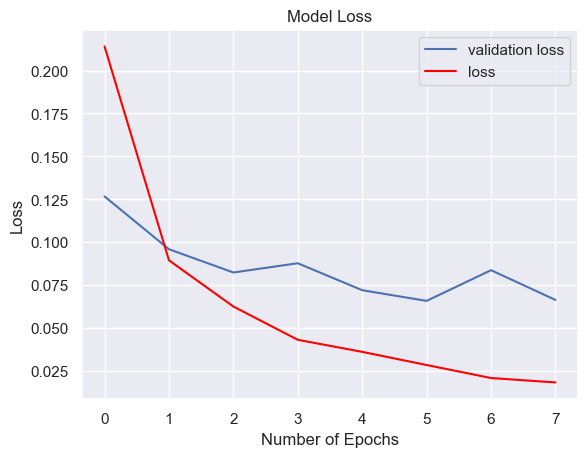

In [13]:
# Define the callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('rnn_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

hist = model.fit(X_res,y_res,validation_data=(X_test,y_test),epochs=15,batch_size=64, callbacks=[early_stop, model_checkpoint])
# Load the best model weights
model.load_weights('rnn_weights.h5')

plt.plot(hist.history['val_loss'], color='b', label="validation loss")
plt.plot(hist.history['loss'], color='red', label="loss")
plt.title("Model Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
test_probs = model.predict(X_test, batch_size=64)
test_preds = (test_probs >= 0.5).astype(int)

test_accuracy = accuracy_score(y_test, test_preds)

print(f"RNN test accuracy score : {test_accuracy}")

56/56 [==============================] - 5s 80ms/step
RNN test accuracy score : 0.9801454138702461


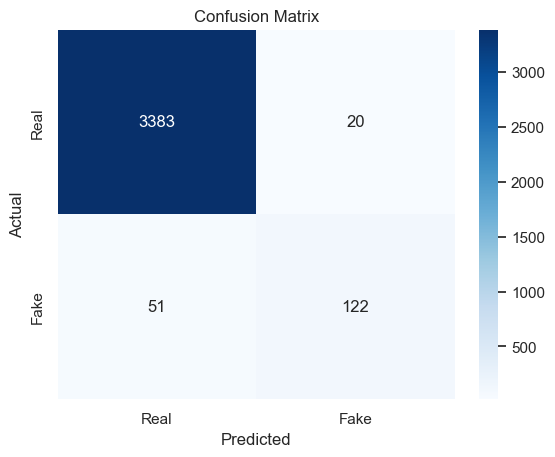

True Positive Rate: 0.7052023121387283
True Negative Rate: 0.994122832794593
False Positive Rate: 0.0058771672054069935
False Negative Rate: 0.2947976878612717
Accuracy: 0.9801454138702461
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.86      0.71      0.77       173

    accuracy                           0.98      3576
   macro avg       0.92      0.85      0.88      3576
weighted avg       0.98      0.98      0.98      3576



In [15]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, test_preds)

# Define the class labels
class_names = ['Real', 'Fake']

# Create a heatmap of the confusion matrix
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Set the axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

TPR = TP / (TP + FN)
print("True Positive Rate:", TPR)
TNR = TN / (TN + FP) 
print("True Negative Rate:", TNR)
FPR = FP / (FP + TN)
print("False Positive Rate:", FPR)
FNR = FN / (TP + FN)
print("False Negative Rate:", FNR)
ACC = (TP + TN) / (TP + FP + FN + TN)
print("Accuracy:", ACC)

print(metrics.classification_report(y_test, test_preds))